# Imports

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Leitura

In [2]:
path = '../data/ibovespa.csv'

In [3]:
# Load your time series data into a DataFrame
# Assuming a column 'date' for the timestamps and 'value' for the values
data = pd.read_csv(path)

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Set 'date' column as the index
data.set_index('date', inplace=True)

In [4]:
# Specify the desired frequency, for example, 'D' for daily
desired_frequency = 'D'

# Use the asfreq() method to change the frequency
data = data.asfreq(desired_frequency)

In [5]:
data.index

DatetimeIndex(['2000-12-27', '2000-12-28', '2000-12-29', '2000-12-30',
               '2000-12-31', '2001-01-01', '2001-01-02', '2001-01-03',
               '2001-01-04', '2001-01-05',
               ...
               '2023-08-07', '2023-08-08', '2023-08-09', '2023-08-10',
               '2023-08-11', '2023-08-12', '2023-08-13', '2023-08-14',
               '2023-08-15', '2023-08-16'],
              dtype='datetime64[ns]', name='date', length=8268, freq='D')

In [6]:
# Check the frequency of the date index
freq = pd.infer_freq(data.index)
print("Frequency:", freq)

Frequency: D


# ARIMA (AutoRegressive Integrated Moving Average):

In [7]:
data_arima = data.copy()

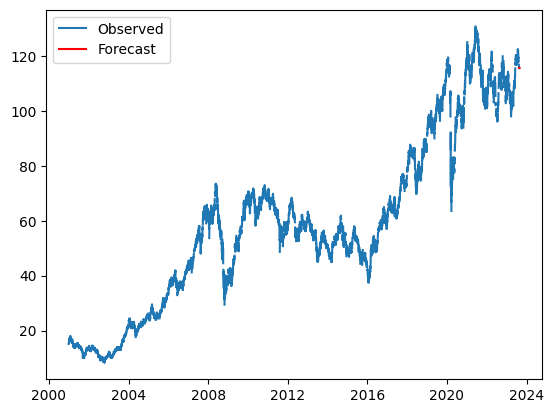

In [8]:
# Define the ARIMA model
p, d, q = 1, 1, 1  # Example values for p, d, and q (order of AR, I, and MA terms)
model = ARIMA(data_arima['value'], order=(p, d, q))

# Fit the model
results = model.fit()

# Generate forecasts
forecast_steps = 10  # Example number of steps ahead
forecast = results.forecast(steps=forecast_steps)

# Create a date range for the forecasted values
forecast_index = pd.date_range(start=data_arima.index[-1], periods=forecast_steps+1, freq='D')

# Combine forecast values with the date index
forecast_series = pd.Series(forecast, index=forecast_index, name='Forecast')

# Plot the original data and the forecasted values
plt.plot(data.index, data_arima['value'], label='Observed')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Evaluate the forecast performance
# Handle missing values in actual data
actual = data_arima['value'].tail(forecast_steps).values  # Use the last 'forecast_steps' actual values
actual = np.nan_to_num(actual)  # Replace NaN with 0, you can choose a different strategy if needed
predicted = forecast  # Forecasted values

mae = mean_absolute_error(actual, forecast)
mse = mean_squared_error(actual, forecast)
rmse = math.sqrt(mse)
epsilon = 1e-10  # Small constant to prevent division by zero
mape = np.mean(np.abs(forecast - actual) / (np.abs(actual) + epsilon)) * 100


print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 24.783586563219615
MSE: 2682.629327956522
RMSE: 51.79410514678791
MAPE: 23143134520712.8


In [10]:
# Defina o limite de precisão (1%)
limite_precisao = 0.01  # 1%

# Calcule a diferença percentual entre as previsões e os valores reais
diferenca_percentual = abs(predicted - actual) / actual

# Calcule a acurácia (percentual de previsões dentro do limite)
acuracia = (diferenca_percentual <= limite_precisao).mean() * 100

# Compare com o limiar desejado (70%)
limiar_desejado = 70

if acuracia >= limiar_desejado:
    print(f"O modelo atingiu uma acurácia de {acuracia:.2f}%, que é maior que o limiar de {limiar_desejado}%.")
else:
    print(f"O modelo não atingiu a acurácia desejada. A acurácia é de {acuracia:.2f}%.")


O modelo não atingiu a acurácia desejada. A acurácia é de 30.00%.


# SARIMA (Seasonal ARIMA):

In [11]:
data_sarima = data.copy()

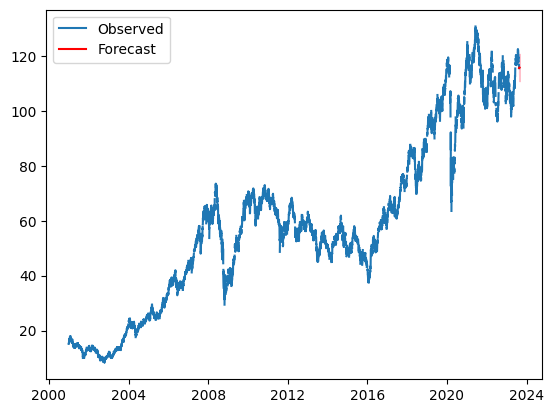

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12  # Example values
model = SARIMAX(data_sarima['value'], order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model
results = model.fit()

# Generate forecasts
forecast_steps = 10  # Example number of steps ahead
forecast = results.get_forecast(steps=forecast_steps)

# Create a new index for the forecasted values with the correct number of periods
forecast_index = pd.date_range(start=data_sarima.index[-1], periods=forecast_steps, freq='D')

# Add the new index to the forecast DataFrame
forecast.index = forecast_index

# Plot the original data and the forecasted values
plt.plot(data_sarima.index, data['value'], label='Observed')
plt.plot(forecast.index, forecast.predicted_mean, label='Forecast', color='red')

# Convert confidence intervals to arrays
ci_lower = forecast.conf_int().to_numpy()[:, 0]
ci_upper = forecast.conf_int().to_numpy()[:, 1]

plt.fill_between(forecast.index, ci_lower, ci_upper, color='pink')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Evaluate the forecast performance
# Handle missing values in actual data
actual = data_sarima['value'].tail(forecast_steps).values  # Use the last 'forecast_steps' actual values
actual = np.nan_to_num(actual)  # Replace NaN with 0, you can choose a different strategy if needed
predicted = forecast.conf_int().to_numpy()[:, 0]  # Forecasted values

mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)
epsilon = 1e-10  # Small constant to prevent division by zero
mape = np.mean(np.abs(predicted - actual) / (np.abs(actual) + epsilon)) * 100


print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 26.73041831734514
MSE: 2521.6389396975787
RMSE: 50.21592316882742
MAPE: 22349671018078.996


In [14]:
# Calcule a diferença percentual para cada par de previsão e valor real
diferencas_percentuais = [abs(p - a) / a if a != 0 else 0 for p, a in zip(predicted, actual)]

# Calcule a acurácia (percentual de previsões dentro do limite)
acuracia = (sum(1 for diff in diferencas_percentuais if diff <= limite_precisao) / len(predicted)) * 100

# Compare com o limiar desejado (70%)
limiar_desejado = 70

if acuracia >= limiar_desejado:
    print(f"O modelo atingiu uma acurácia de {acuracia:.2f}%, que é maior que o limiar de {limiar_desejado}%.")
else:
    print(f"O modelo não atingiu a acurácia desejada. A acurácia é de {acuracia:.2f}%.")

O modelo não atingiu a acurácia desejada. A acurácia é de 20.00%.


# Prophet

In [15]:
data_prophet = data.copy().dropna()

c:\Users\Igor\Documents\GitHub\Tech_Challenge_Fase02\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
20:33:02 - cmdstanpy - INFO - Chain [1] start processing
20:33:05 - cmdstanpy - INFO - Chain [1] done processing


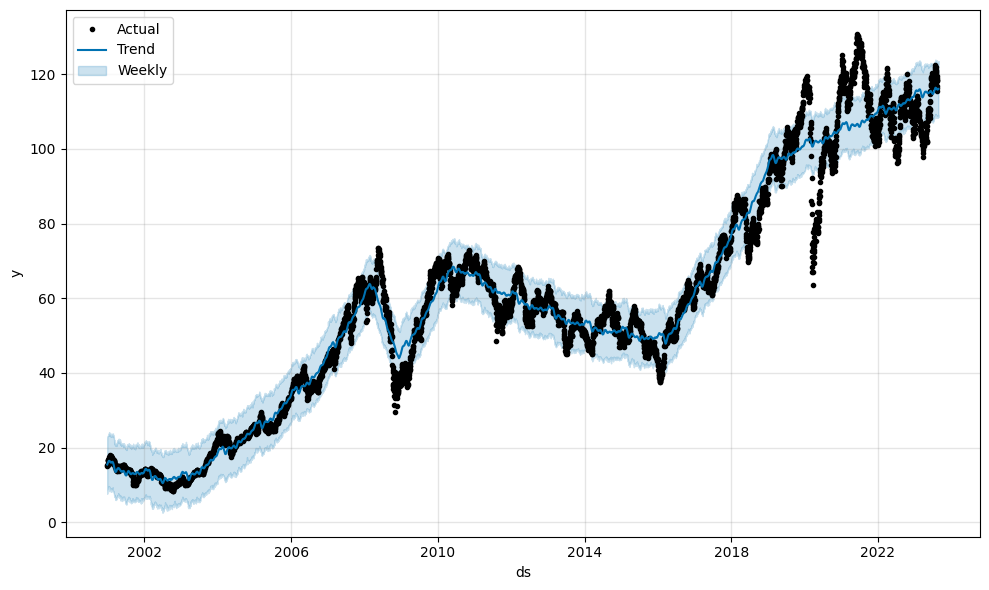

In [16]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare the data in the required format
data_prophet = data_prophet.reset_index()
data_prophet.rename(columns={'date': 'ds', 'value': 'y'}, inplace=True)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(data_prophet)

# Generate forecasts
forecast_steps = 10  # Example number of steps ahead

# Create a DataFrame for future predictions
future = model.make_future_dataframe(periods=forecast_steps)

# Generate forecasts
forecast = model.predict(future)

# Plot the forecasted values
fig = model.plot(forecast)

# Add a legend
plt.legend(["Actual", "Trend", "Weekly", "Yearly", "Forecast"])
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np

actual_values = data_prophet['y'][-forecast_steps:]
forecasted_values = forecast['yhat'][-forecast_steps:]

mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)
rmse = np.sqrt(mse)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actual_values, forecasted_values)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 2.3309377410451235
MSE: 7.449466804881848
RMSE: 2.729371137255219
MAPE: nan


In [18]:
# Defina o limite de precisão (1%)
limite_precisao = 0.01  # 1%

# Calcule a diferença percentual entre as previsões e os valores reais
diferenca_percentual = abs(predicted - actual) / actual

# Calcule a acurácia (percentual de previsões dentro do limite)
acuracia = (diferenca_percentual <= limite_precisao).mean() * 100

# Compare com o limiar desejado (70%)
limiar_desejado = 70

if acuracia >= limiar_desejado:
    print(f"O modelo atingiu uma acurácia de {acuracia:.2f}%, que é maior que o limiar de {limiar_desejado}%.")
else:
    print(f"O modelo não atingiu a acurácia desejada. A acurácia é de {acuracia:.2f}%.")


O modelo não atingiu a acurácia desejada. A acurácia é de 0.00%.


C:\Users\Igor\AppData\Local\Temp\ipykernel_15280\1991689764.py:5: RuntimeWarning: divide by zero encountered in divide
  diferenca_percentual = abs(predicted - actual) / actual
